**Spike Generation Function**

In [17]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim

# Directory containing CSV files
directory_path = '/kaggle/input/thesis/databasae'
output_directory = '/kaggle/working/spike_output'  # New folder for saving generated spikes
os.makedirs(output_directory, exist_ok=True)  # Create the output directory if it doesn't exist

# Get all CSV file paths from the directory
all_csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]

# Select 5 random CSV files
selected_files = random.sample(all_csv_files, 15)

# Function to encode EEG signal using BSA
def BSA_encode(S, thresholdBSA):
    B = (S > thresholdBSA).astype(int)  # Create a binary spike train based on the threshold
    S_modified = S * B
    return B, S_modified

# Function to optimize EEG signal using BSA
def optimize_eeg_signal(file_path, num_particles=100, num_iterations=20):
    # Load the EEG data
    df = pd.read_csv(file_path)
    channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

    def calculate_fitness(original_signal, reconstructed_signal):
        mse = mean_squared_error(original_signal, reconstructed_signal)
        rmse = np.sqrt(mse)
        pcc, _ = pearsonr(original_signal, reconstructed_signal)
        snr = 10 * np.log10(np.sum(np.square(original_signal)) / np.sum(np.square(original_signal - reconstructed_signal)))
        psnr = 10 * np.log10(np.max(np.square(original_signal)) / mse)
        cos_sim = cosine_similarity([original_signal], [reconstructed_signal])[0][0]
        ssim_value = ssim(original_signal, reconstructed_signal, data_range=original_signal.max() - original_signal.min())
        
        # Combine all metrics for the final fitness score
        # Minimize MSE and RMSE, maximize SNR, PSNR, PCC, Cosine Similarity, and SSIM
        fitness = -mse + -rmse + (snr * 10) + (psnr * 5) + (pcc * 100) + (cos_sim * 100) + (ssim_value * 100)
        return fitness

    # PSO Parameters
    inertia_weight = 0.7
    cognitive_weight = 1.5
    social_weight = 1.5

    # Initialize particle population
    def initialize_particles(size):
        particles = []
        for _ in range(size):
            # Randomly initialize thresholds for BSA
            position = (random.uniform(0.0, 1.0),)  # Threshold BSA
            velocity = (random.uniform(-0.1, 0.1),)  # Velocity for BSA threshold
            particles.append((position, velocity, position))  # (position, velocity, personal best)
        return particles

    # Main PSO Loop
    def particle_swarm_optimization(df, num_particles, num_iterations):
        particles = initialize_particles(num_particles)
        global_best_position = None
        global_best_fitness = -np.inf

        for iteration in tqdm(range(num_iterations), desc="Running Iterations"):
            for i in range(num_particles):
                position, velocity, personal_best = particles[i]

                # Assume we're processing the first channel for simplicity
                eeg_channel_data = df[channels[0]].values

                # Apply BSA and reconstruct
                spike_train_bsa, modified_signal_bsa = BSA_encode(eeg_channel_data, position[0])
                reconstructed_bsa = modified_signal_bsa

                # Calculate fitness
                fitness_bsa = calculate_fitness(eeg_channel_data, reconstructed_bsa)

                # Update personal best
                if fitness_bsa > calculate_fitness(eeg_channel_data, BSA_encode(eeg_channel_data, personal_best[0])[1]):
                    personal_best = position

                # Update global best
                if fitness_bsa > global_best_fitness:
                    global_best_fitness = fitness_bsa
                    global_best_position = position

                # Update velocity and position
                new_velocity = (
                    inertia_weight * velocity[0] +
                    cognitive_weight * random.random() * (personal_best[0] - position[0]) +
                    social_weight * random.random() * (global_best_position[0] - position[0]),
                )
                new_position = (min(max(position[0] + new_velocity[0], 0.0), 1.0),)  # Clamp BSA threshold

                particles[i] = (new_position, new_velocity, personal_best)

        return global_best_position, global_best_fitness

    # Run the PSO
    global_best_position, global_best_fitness = particle_swarm_optimization(df, num_particles, num_iterations)
    return global_best_position[0], global_best_fitness

# Step 1: Optimize BSA threshold for 5 selected CSV files and calculate the average threshold
bsa_thresholds = []
for path in selected_files:
    best_threshold, _ = optimize_eeg_signal(path, num_particles=10, num_iterations=20)
    bsa_thresholds.append(best_threshold)

average_bsa_threshold = np.mean(bsa_thresholds)
print(f"Average BSA Threshold: {average_bsa_threshold}")

# Step 2: Generate spikes for all CSV files using the average BSA threshold and save the results
def generate_spikes_and_save(file_path, threshold, output_directory):
    df = pd.read_csv(file_path)
    channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

    # Initialize a DataFrame for spikes
    spikes_df = pd.DataFrame()

    for channel in channels:
        eeg_channel_data = df[channel].values
        spike_train_bsa, _ = BSA_encode(eeg_channel_data, threshold)
        spikes_df[channel] = spike_train_bsa

    # Save the spikes data as a CSV file
    output_file_name = os.path.basename(file_path).replace('.csv', '_spikes.csv')
    output_file_path = os.path.join(output_directory, output_file_name)
    spikes_df.to_csv(output_file_path, index=False)

# Step 3: Apply BSA to all files and save
for file_path in tqdm(all_csv_files, desc="Generating Spikes"):
    generate_spikes_and_save(file_path, average_bsa_threshold, output_directory)

print(f"Spikes have been saved in {output_directory}")


Running Iterations: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Average BSA Threshold: 0.8109924107128743


Generating Spikes: 100%|██████████| 112/112 [00:32<00:00,  3.49it/s]

Spikes have been saved in /kaggle/working/spike_output


/tmp/ipykernel_30/281534883.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


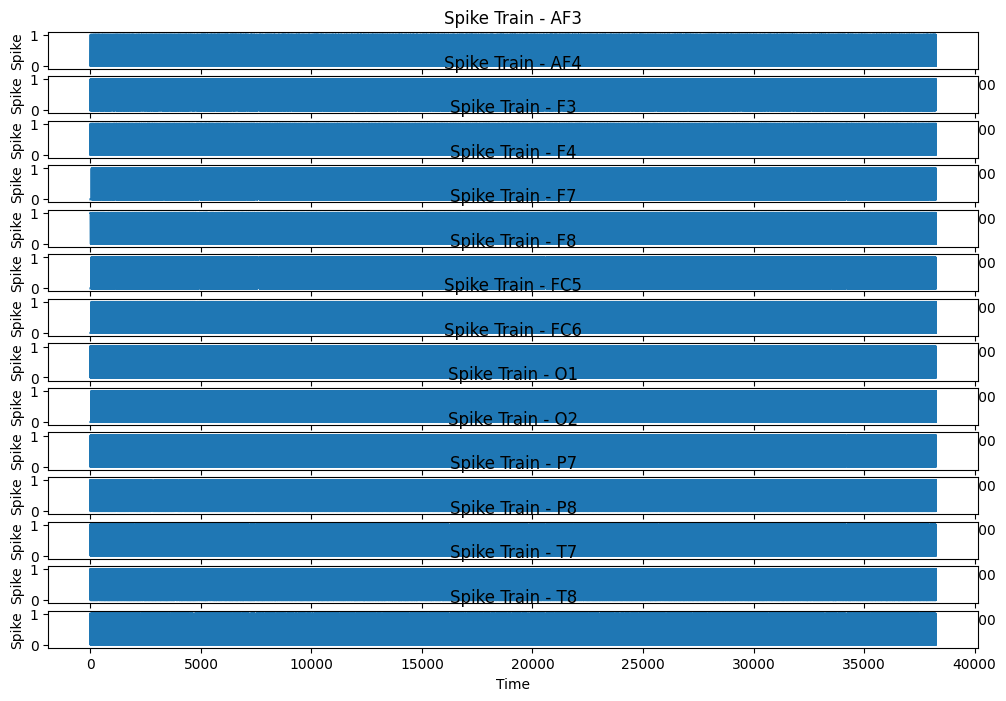

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the spike data from the CSV file
file_path = '/kaggle/working/spike_output/S02G2AllChannels_spikes.csv'
spike_data = pd.read_csv(file_path)

# Plot spikes for each channel
channels = spike_data.columns  # Assuming each column represents a channel

plt.figure(figsize=(12, 8))

for i, channel in enumerate(channels):
    plt.subplot(len(channels), 1, i + 1)  # Create a subplot for each channel
    plt.plot(spike_data[channel], drawstyle='steps-post')
    plt.title(f"Spike Train - {channel}")
    plt.ylabel('Spike')
    plt.xlabel('Time')
    plt.ylim(-0.1, 1.1)  # Spikes are binary (0 or 1)

plt.tight_layout()
plt.show()


Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   149.418 secs
Ready.
Overwriting existing file.
Writing /kaggle/working/spike_output/spike_data.fif
Closing /kaggle/working/spike_output/spike_data.fif
[done]


/tmp/ipykernel_30/3899749396.py:25: RuntimeWarning: This filename (/kaggle/working/spike_output/spike_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_fif_file, overwrite=True)


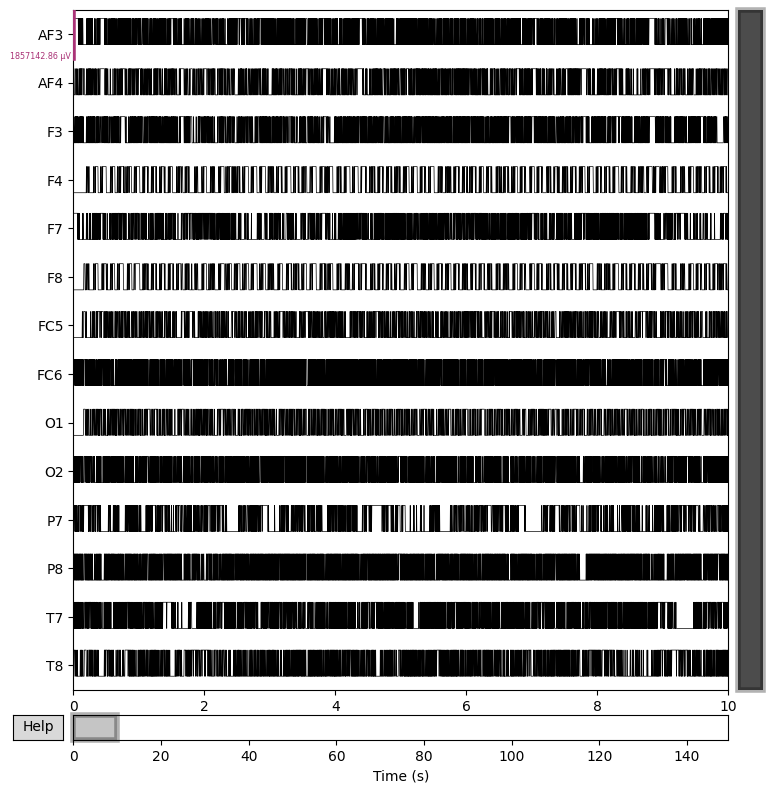

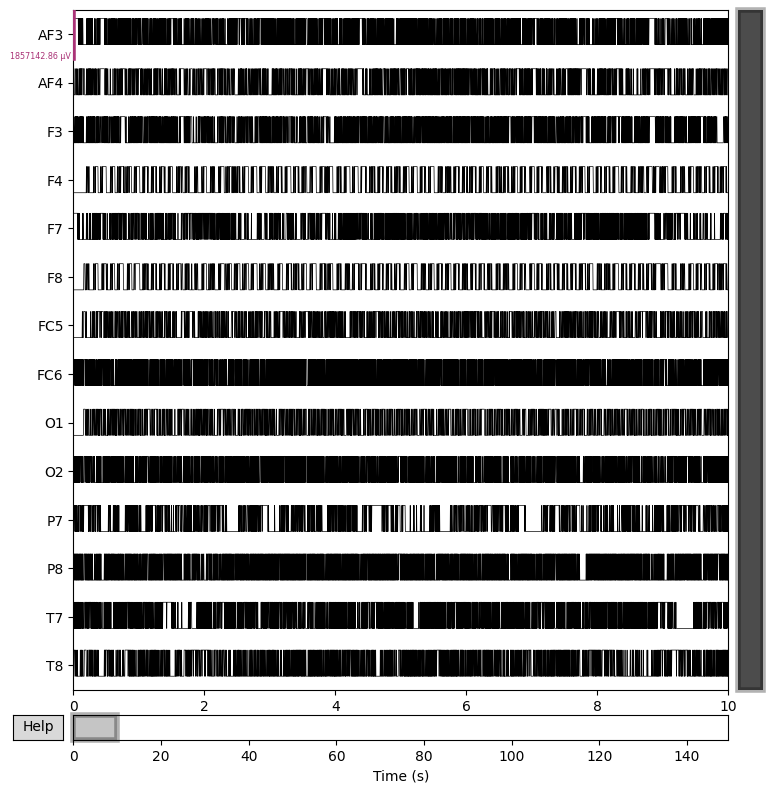

In [19]:
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the spike data from the CSV file
file_path = '/kaggle/working/spike_output/S02G2AllChannels_spikes.csv'
spike_data = pd.read_csv(file_path)

# Assuming your sampling frequency is 256 Hz (modify this according to your actual data)
sfreq = 256
channels = spike_data.columns  # Get channel names

# Convert the spike data to a NumPy array and transpose it (MNE expects channels x time format)
data = spike_data.values.T

# Create MNE info structure
info = mne.create_info(ch_names=list(channels), sfreq=sfreq, ch_types=['eeg'] * len(channels))

# Create MNE RawArray object from the spike data
raw = mne.io.RawArray(data, info)

# Save as a .fif file
output_fif_file = '/kaggle/working/spike_output/spike_data.fif'
raw.save(output_fif_file, overwrite=True)

# Plot the data
raw.plot(scalings='auto', show=True, title='Spike Data Plot')
